## Práctica 3 - Deep Learning: Perceptrón Multicapa

***
Esta práctica ha sido llevada a cabo en solitario por Jaime Alonso Fernández (2024/2025) para la asignatura optativa "Aprendizaje Automático y Big Data" en el grado de "Ingeniería del Software - plan 2019" cursado en la Universidad Complutense de Madrid (UCM).
***


Durante este primera apartado, vamos a empezar con un algoritmo generador de datos como aquel visto en la P-2 y entrenar con el un Perceptrón Multicapa con diferentes configuraciones con el fin de comparalas.

Comenzamos importando las librerías:

In [54]:
# Importamos las librerías
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
import time

Tras haber importado las librerías que consideramos necesarias, procedemos a traernos del proyecto anterior toda el código para generar nuestra sample:

In [55]:
# Definimos las constantes
# -- Arterial
MIN_ARTERIAL = 70
NORMAL_ARTERIAL_LOW = 100
NORMAL_ARTERIAL_HIGH = 120
MAX_ARTERIAL = 180
# -- Colesterol
MIN_COLESTEROL = 120
NORMAL_COLESTEROL_LOW = 120
NORMAL_COLESTEROL_HIGH = 180
MAX_COLESTEROL = 250

In [56]:
# Método general de generación del dataset
def generate_people(n: int) -> np.array:
    # Iniciamos el dataset como una lista
    dataset = []
    for _ in range(n):
        # Creamos un dataelement como una lista
        dataelement = []
        # Presión arterial 
        dataelement.append(np.random.randint(MIN_ARTERIAL, MAX_ARTERIAL + 1))
        # Colesterol 
        dataelement.append(np.random.randint(MIN_COLESTEROL, MAX_COLESTEROL + 1))
        # Añadimos el dataelement al dataset
        dataset.append(dataelement)
    # Transformamos el dataset a un array de numpy
    dataset = np.array(dataset)
    return dataset
    

# Calculamos las probabilidades
def compute_probability_illness(dataset:np.array) -> np.array:
    arterial, colesterol = dataset[:, 0], dataset[:, 1]
        
    prob_arterial = np.where(arterial < NORMAL_ARTERIAL_LOW,  # Si la presión arterial es menor a la normal menor
                            (NORMAL_ARTERIAL_LOW - arterial) / (NORMAL_ARTERIAL_LOW - MIN_ARTERIAL), # El riesgo es el índice de desviación
                            np.where(arterial > NORMAL_ARTERIAL_HIGH, # Si es mayor a la normal mayor
                                        (arterial - NORMAL_ARTERIAL_HIGH) / (MAX_ARTERIAL - NORMAL_ARTERIAL_HIGH), # El riesgo es el índice de desviación
                                        0)) # Si no es ni menor a la normal menor ni mayor a normal mayor, el riesgo es 0

    prob_colesterol = np.where(colesterol > NORMAL_COLESTEROL_HIGH, # Si el colesterol es mayor al máximo normal
                                (colesterol - NORMAL_COLESTEROL_HIGH) / (MAX_COLESTEROL - NORMAL_COLESTEROL_HIGH), # El riesgo es el índice de desviación
                                0) # Si no el riesgo es 0


    # Todas las probabilidades ostentan un mismo peso que suman como máximo 1
    total_prob = 1/2 * prob_colesterol + 1/2 * prob_arterial

    # Devolvemos el dataset añadiendole una nueva columna
    return np.column_stack((dataset, total_prob))


# Funcion que aplica cota sobre datos
def apply_threshold(threshold:float, dataset:np.array) -> np.array:
    risk_class = np.where(dataset[:, -1] > threshold, 1, 0)
    return np.column_stack((dataset, risk_class))

def get_dataset(n:int) -> np.array:
    people = generate_people(n) # Generamos un dataset
    people = apply_threshold(0.5, compute_probability_illness(people)) # Le añadimos las columnas de probabilidad en formato binario
    return people

In [57]:
# Generamos el dataset de trabajo
sample_people = get_dataset(1000)

# Dividimos el dataset en entrenamiento y pruebas usando un factor de 80-20
train_people, test_people = train_test_split(sample_people, test_size=0.2)

scaler = StandardScaler()
# Definimos las variables de entrada para el entreno
X = train_people[:, 0:2]
y = train_people[:, -1]
# Y la escalamos
X = scaler.fit_transform(X)

X_test = test_people[:, 0:2]
X_test = scaler.transform(X_test)

Ahora ya podemos comenzar con el desarrollo de la práctica. Para ello primero veremos las propiedades del MLP y luego iremos haciendo variaciones sobre las mismas observando el resultado.


Las propiedades que recibe el clasificador MLP son las siguientes:

- **solver**: Define el algoritmo que vaya a usar el MLP. Debido a las pocas variables con las que contamos (2), el más eficiente sería `lbfgs` (Limited BFGS).  
- **alpha**: Es un parámetro de penalización pensado para evitar el *overfitting*.  
- **hidden_layer_sizes**: Número de neuronas por cada capa oculta. (50, 2) implicaría una capa oculta de 50 neuronas y otra de 2.  
- **random_state**: Garantiza la misma generación de números aleatorios.  
- **learning_rate**: Es la tasa de adaptación de los pesos. Hay tres opciones `constant`, `invscaling`, y `adaptative`
- **activation**: Es la función de activación para las capas ocultas. Esta sirve para introducir no-linealidades en el modelo. Existen 4 opciones: `identity` (lineal),
`logistic`,`tanh` (tangente hiperbólica) y `relu`.

# *Underfitting* y *Overfitting* mediante **hidden_layer_sizes**:
En este caso, dado que el conjunto de entrenamiento consta de 800 muestras, el número de neuronas en las capas ocultas debe ser adecuado para lograr un equilibrio entre generalización y ajuste. Un número demasiado bajo de neuronas podría provocar *underfitting*, impidiendo que el modelo capture patrones relevantes. Por otro lado, un número excesivo de neuronas podría llevar a *overfitting*, causando una cota demasiado exigente.  

In [58]:
# Creamos la instancia del modelo a entrenar
# Para una muestra de 800 elementos, estableceré varias hidden_layers de un tamaño acorde
mlp = MLPClassifier(solver = 'lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 500, 300, 200, 100, 1), random_state=1)    

# Procedemos a entrenar el modelo, le pasamos en el parámetro 1 las filas de datos, y en el 2 sus resultados booleanos 
mlp.fit(X, y)
# Probamos a predecir comparando con los resultados
prediction_1 = mlp.predict(X_test)

# Lo mostramos en el notebook
prediction_1


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
mlp.score(X_test, test_people[:, -1])

0.79

En el caso anterior, vemos que la matriz de resultados es igual a `ZERO`, siendo una muestra clara de que existe *overfitting*. Esto se debe en parte a la diferencia de tamños de las capas iniciales, comenzado con reducciones muy grandes y acotando bastante al final. Esto se podría solucionar decrementando el tamaño del paso entre una capa u otra y el nivel de convergencia. Probemoslo:

In [60]:
# Para una muestra de 800 elementos, estableceré varias hidden_layers de un tamaño acorde
mlp2 = MLPClassifier(solver = 'lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 100, 60, 50), random_state=1)    

# Procedemos a entrenar el modelo, le pasamos en el parámetro 1 las filas de datos, y en el 2 sus resultados booleanos 
mlp2.fit(X, y)
# Probamos a predecir comparando con los resultados
prediction_2 = mlp2.predict(X_test)

prediction_2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])

In [61]:
mlp2.score(X_test, test_people[:, -1])

0.995

Para este caso volvemos a utilizar el mismo número de neuronas finales, aún convergentes pero con una reducción menor y más repartidas: `(150,100,60,50)`
$$
150+100+60+50 = 360 \text{ neuronas totales en la hidden layer}
$$
Con ello podemos apreciar dos cosas. Por una parte la matriz de resultados no es una matriz `ZERO`, y con ello la tasa de acierto a subido aproximadamente un 17% prácticamente maximizandose (muy próximo al 100% de precisión). Por esto es crucial no solo conocer los límites de tu modelo si no entender como ha de ser la distribución eficiente de las capas ocultas.

Ahora que ya mostramos el *overfitting*, podemos pasar a enseñar el *underfitting*. Para ello tendremos que establecer un número muy bajo de neuronas en representación con nuestro dataset. Para ello lo que debemos de establecer es un número relativamente bajo de neruonas en las hidden layer en comparación con el campo de entrada.

En nuestro caso podemos obtener *underfitting* con por ejemplo 5 neuronas. Veámoslo:

In [62]:
# Para una muestra de 800 elementos, estableceré varias hidden_layers de un tamaño acorde
mlp3 = MLPClassifier(solver = 'lbfgs', alpha=1e-5, hidden_layer_sizes=(1), random_state=1)    

# Procedemos a entrenar el modelo, le pasamos en el parámetro 1 las filas de datos, y en el 2 sus resultados booleanos 
mlp3.fit(X, y)
# Probamos a predecir comparando con los resultados
prediction_3 = mlp3.predict(X_test)

prediction_3

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
mlp3.score(X_test, test_people[:, -1])

0.79

Y como podemos apreciar, el resultado es similar por no decir idéntico a aquellos casos en los que el tenemos *overfitting*, al final para ambos casos la matriz de resultados es idéntica e igual a `ZERO`.

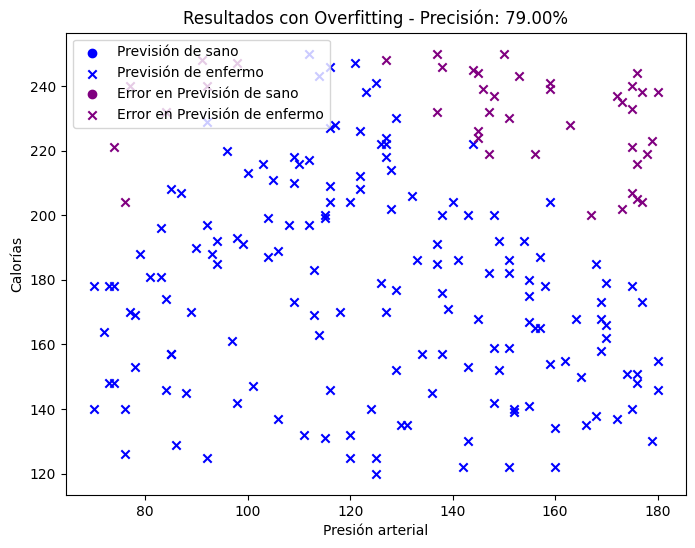

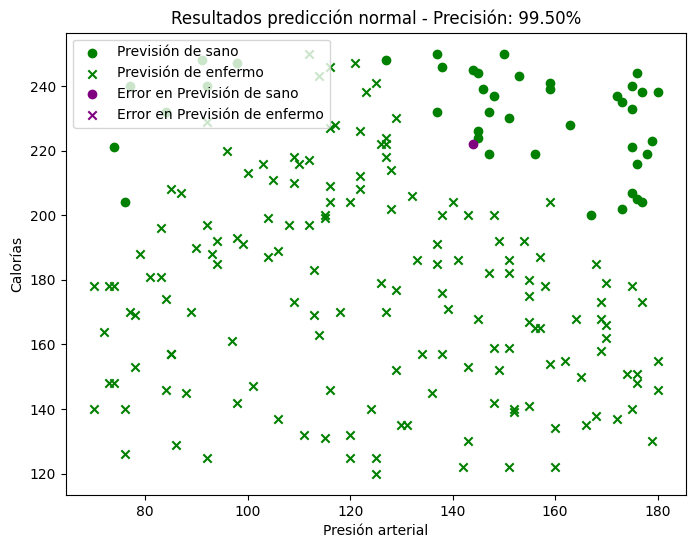

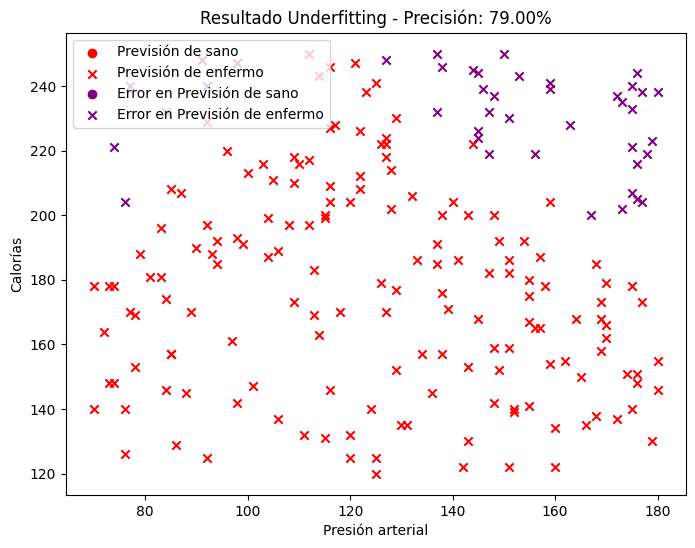

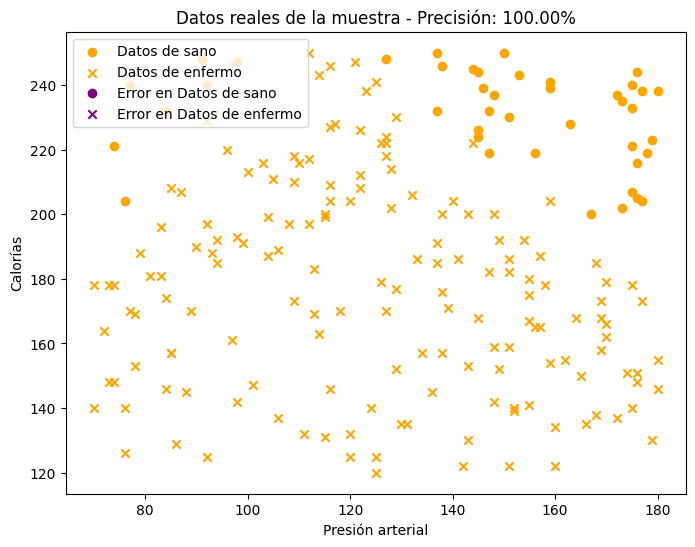

In [64]:
# Función para graficar con los estilos adecuados
def plot_predictions(predictions, color, label_x, label_o, title, time=None):
    x = test_people[:, 0]
    y = test_people[:, 1]
    
    plt.figure(figsize=(8, 6))
    
    predictions = predictions
    true_labels = test_people[:, -1]

    # Verificar dimensiones
    if predictions.shape[0] != x.shape[0]:
        raise ValueError("Las predicciones deben tener la misma longitud que x e y.")

    # Identificar aciertos y errores
    correct = predictions == true_labels
    incorrect = ~correct  # Invertir valores booleanos

    # Filtrar los puntos correctos
    x_o_correct, y_o_correct = x[(predictions == 1) & correct], y[(predictions == 1) & correct]
    x_x_correct, y_x_correct = x[(predictions == 0) & correct], y[(predictions == 0) & correct]

    # Filtrar los puntos incorrectos
    x_o_wrong, y_o_wrong = x[(predictions == 1) & incorrect], y[(predictions == 1) & incorrect]
    x_x_wrong, y_x_wrong = x[(predictions == 0) & incorrect], y[(predictions == 0) & incorrect]

    # Graficar los puntos correctamente clasificados
    plt.scatter(x_o_correct, y_o_correct, color=color, marker='o', label=label_o)
    plt.scatter(x_x_correct, y_x_correct, color=color, marker='x', label=label_x)

    # Graficar los puntos incorrectamente clasificados en púrpura
    plt.scatter(x_o_wrong, y_o_wrong, color='purple', marker='o', label=f"Error en {label_o}")
    plt.scatter(x_x_wrong, y_x_wrong, color='purple', marker='x', label=f"Error en {label_x}")

    # Calcular precisión
    accuracy = np.mean(correct) * 100

    # Ajustar etiquetas
    plt.xlabel("Presión arterial")
    plt.ylabel("Calorías")
    plt.legend()
    if time is None:
        plt.title(f"{title} - Precisión: {accuracy:.2f}%")
    else:
        plt.title(f"{title} - Precisión: {accuracy:.2f}% - Time: {time:.2f}ms")
    plt.show()




# Graficar cada predicción con su color correspondiente
plot_predictions(prediction_1, 'blue', 'Previsión de enfermo', 'Previsión de sano', 'Resultados con Overfitting')
plot_predictions(prediction_2, 'green', 'Previsión de enfermo', 'Previsión de sano', 'Resultados predicción normal')
plot_predictions(prediction_3, 'red', 'Previsión de enfermo', 'Previsión de sano', 'Resultado Underfitting')
plot_predictions(test_people[:, -1], 'orange', 'Datos de enfermo', 'Datos de sano', 'Datos reales de la muestra')




Llama la atención como para los casos de overfitting o underfitting ocurre lo mismo, y si bien estos son extremos forzados, vemos que ninguno es capaz de preveer enfermos. Esto es asi ya que cuando existen demasiadas neuronas demasiado complejas, el criterio de aceptación es demasiado preciso. Ocurre a la inversa con falta de neuronas ya que en este caso, el criterio de aceptación es demasiado laxo.

# Variaciones del **learning_rate**:
En el caso anerior hemos visto como las diferentes combinaciones de hidden layers podían causar *overfitting* y *underfitting*. Para esa muestra estabamos también viendo y analizando el comportamiento de **solver=lsgd** el cual no presenta ningún uso de **learning_rate**, por ello para esta prueba he decidido cambiar de modelo a **adam** pero que no hacía falta al ser el valor por defecto de este atributo. Durante esta segunda sección estaremos analizando el comportamiento de otros **learning_rates**, y comparandolos en base a precisión y a tiempo.

Para ello, vamos a utilizar la misma configuración que usamos para el clasificador más preciso del estudio anterios, siendo este `(150, 100, 60, 50)`.


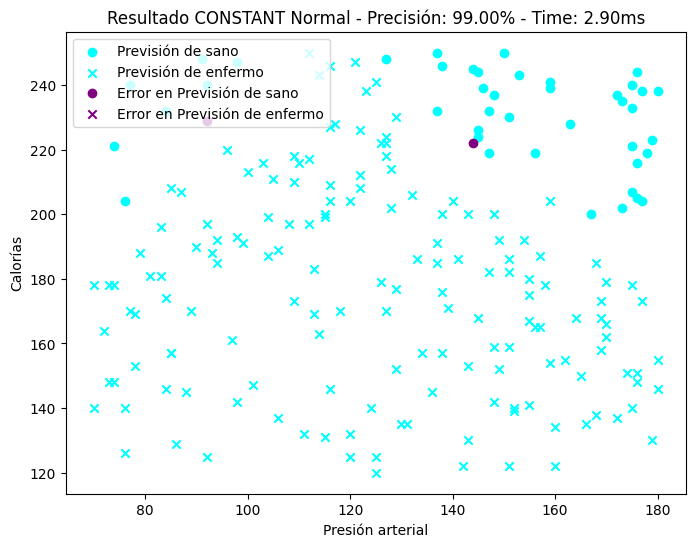

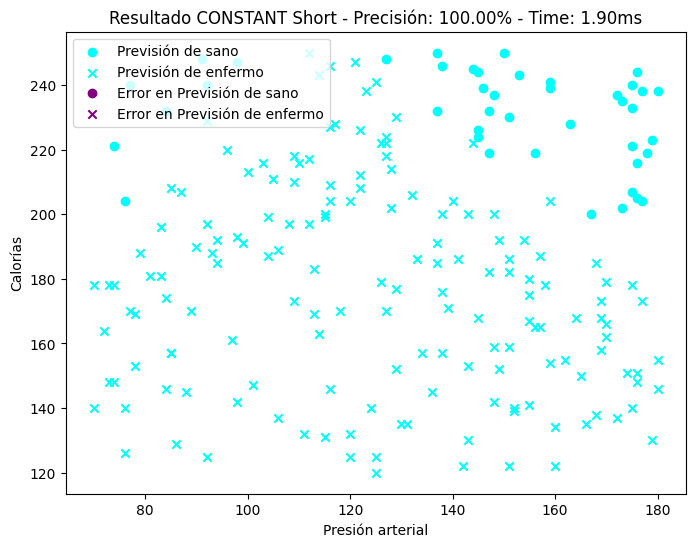

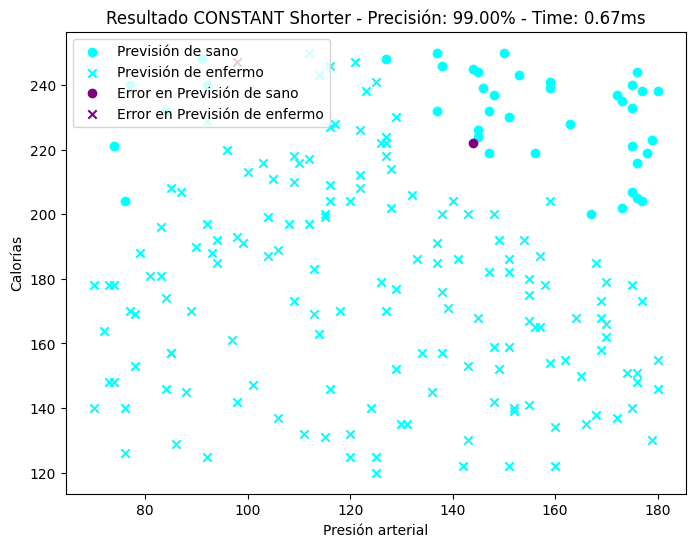

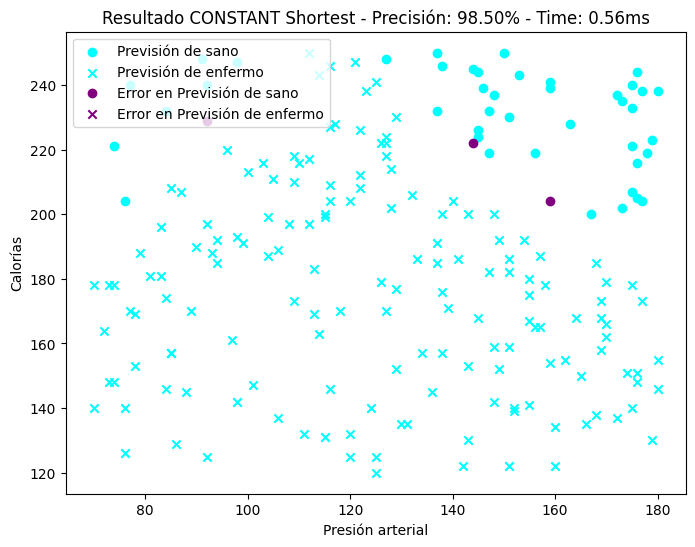

CONSTANT learning rate finished with a mean precission of: 99.125%, a max score of: 100.0% and a min score of 98.5% in 6.034696817398071ms


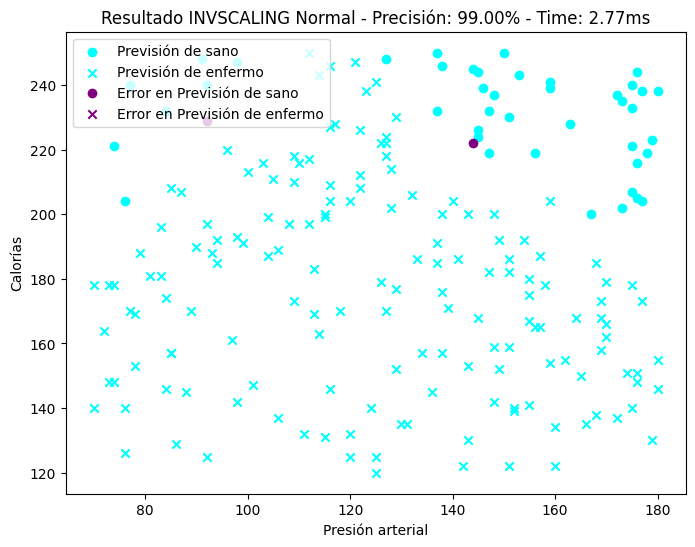

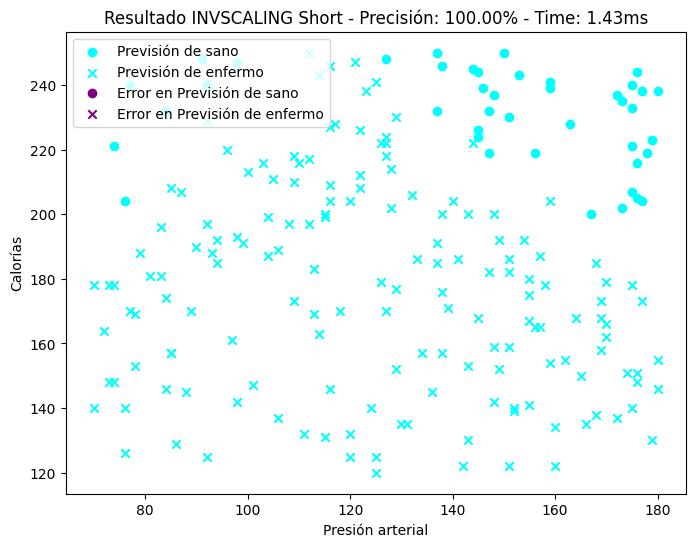

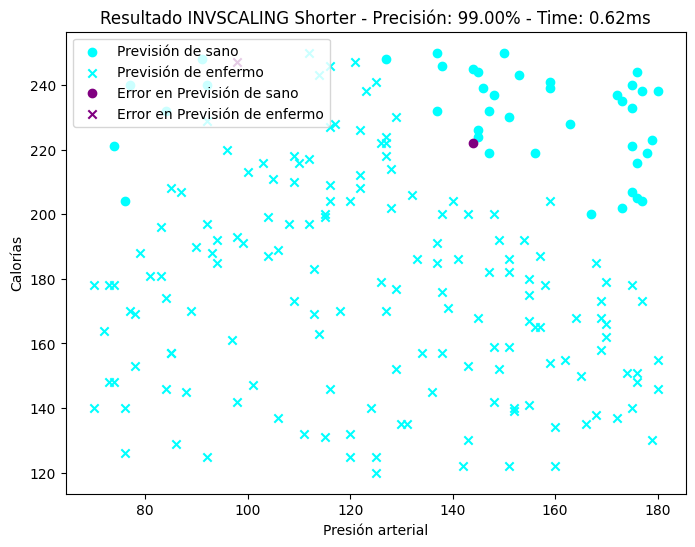

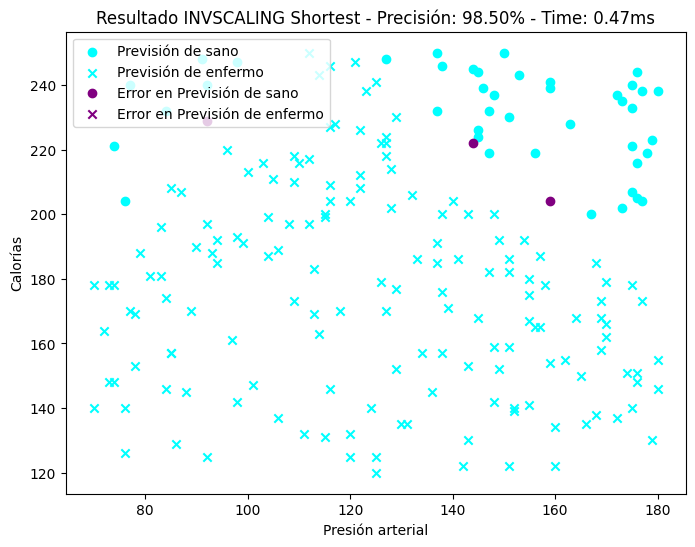

INVSCALING learning rate finished with a mean precission of: 99.125%, a max score of: 100.0% and a min score of 98.5% in 5.296270132064819ms


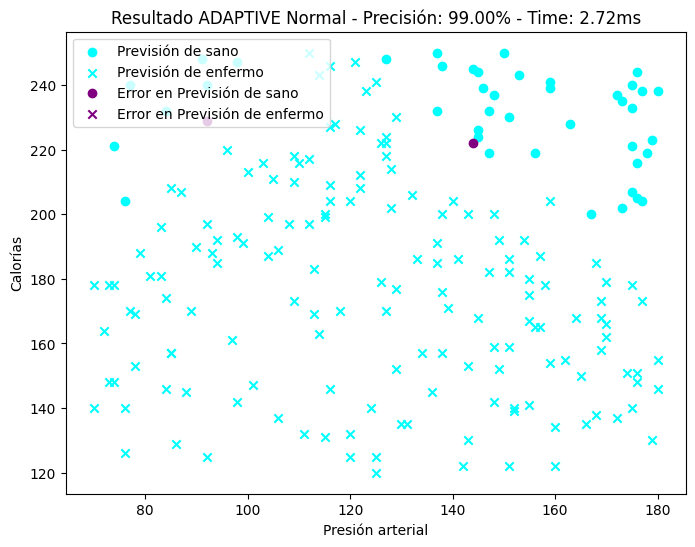

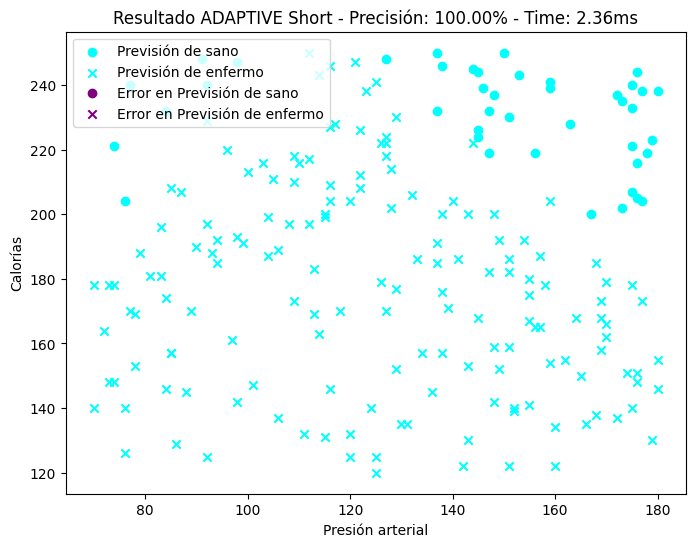

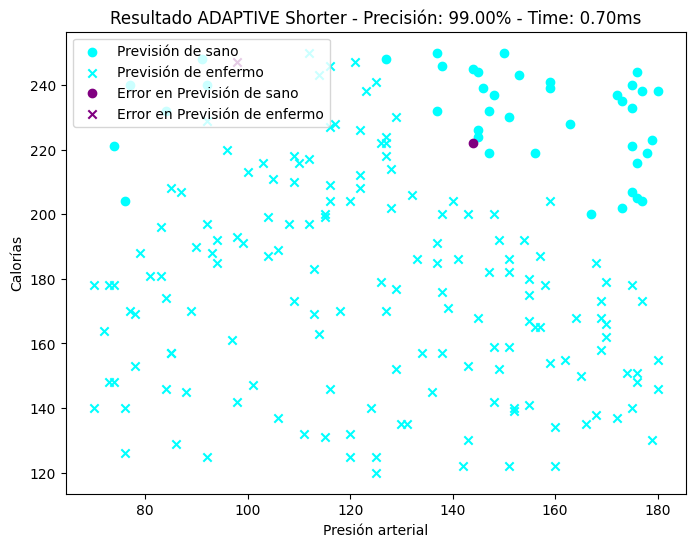

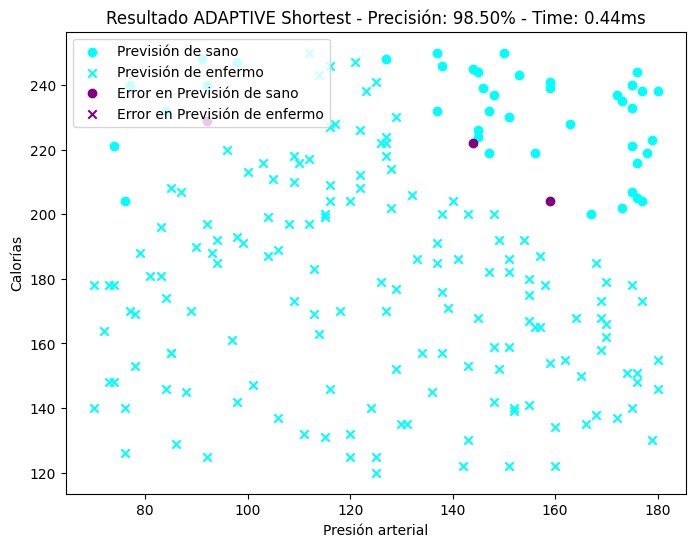

ADAPTIVE learning rate finished with a mean precission of: 99.125%, a max score of: 100.0% and a min score of 98.5% in 6.220125436782837ms


In [ ]:
# Creamos la instancia del modelo a entrenar
learning_rates = ['constant', 'invscaling', 'adaptive']

for lr in learning_rates:
    # Para una muestra de 800 elementos, estableceré varias hidden_layers de un tamaño acorde
    mlp_norm = MLPClassifier(solver = 'adam', alpha=1e-5, hidden_layer_sizes=(150, 100, 60, 20), random_state=1, learning_rate=lr,  max_iter=1000)   
    mlp_short = MLPClassifier(solver = 'adam', alpha=1e-5, hidden_layer_sizes=(100, 60, 20), random_state=1, learning_rate=lr, max_iter=1000)  
    mlp_shorter = MLPClassifier(solver = 'adam', alpha=1e-5, hidden_layer_sizes=(60, 20), random_state=1, learning_rate=lr, max_iter=1000) 
    mlp_shortest = MLPClassifier(solver = 'adam', alpha=1e-5, hidden_layer_sizes=(20), random_state=1, learning_rate=lr, max_iter=1000) 

    # Medimos el tiempo total
    t1 = time.time()

    # Y el que le lleva a cada una
    t_norm = time.time()
    mlp_norm.fit(X, y)
    prediction_norm = mlp_norm.predict(X_test)
    t_norm = time.time() - t_norm

    t_short = time.time()
    mlp_short.fit(X, y)
    prediction_short = mlp_short.predict(X_test)
    t_short = time.time() - t_short

    t_shorter = time.time()
    mlp_shorter.fit(X, y)
    prediction_shorter = mlp_shorter.predict(X_test)
    t_shorter = time.time() - t_shorter

    t_shortest = time.time()
    mlp_shortest.fit(X, y)
    prediction_shortest = mlp_shortest.predict(X_test)
    t_shortest = time.time() - t_shortest

    t2 = time.time()
    
    # Calculamos la precisión de cada uno de los elementos
    score = mlp_norm.score(X_test, test_people[:, -1])*100
    score_short = mlp_short.score(X_test, test_people[:, -1])*100
    score_shorter = mlp_shorter.score(X_test, test_people[:, -1])*100
    score_shortest = mlp_shortest.score(X_test, test_people[:, -1])*100

    # Y la precisión media
    mean_score = (score + score_short + score_shorter + score_shortest) / 4
    max_score = max(score, score_short, score_shorter, score_shortest)
    min_score = min(score, score_short, score_shorter, score_shortest)


    # Y hacemos el plot
    plot_predictions(prediction_norm, 'cyan', 'Previsión de enfermo', 'Previsión de sano', f'Resultado {lr.upper()} Normal', t_norm)
    plot_predictions(prediction_short, 'cyan', 'Previsión de enfermo', 'Previsión de sano', f'Resultado {lr.upper()} Short', t_short)
    plot_predictions(prediction_shorter, 'cyan', 'Previsión de enfermo', 'Previsión de sano', f'Resultado {lr.upper()} Shorter', t_shorter)
    plot_predictions(prediction_shortest, 'cyan', 'Previsión de enfermo', 'Previsión de sano', f'Resultado {lr.upper()} Shortest', t_shortest)

    print(f'{lr.upper()} learning rate finished with a mean precission of: {mean_score}%, a max score of: {max_score}% and a min score of {min_score}% in {t2-t1}ms')

En este caso veremos que todos los métodos lograron exactamente el mismo rendimiento en precisión por lo que la clave a la hora de determinar uno mejor que otro radica en el tiempo. Aqui vemos que:

- INVSCALING fue el más rápido: 5.29 ms

- CONSTANT tomó: 6.03 ms

- ADAPTIVE fue el más lento: 6.22 ms

# Variaciones del **solvers**:
Ya hemos visto el *overfitting* y *underfitting* según las hidden layers, así como las diferencias entre las learning rates. Finalmente haremos una comparativa entre los diferentes solvers.

Para ello, vamos a utilizar dos configuraciones, una es la misma configuración que usamos para el clasificador más preciso del estudio anterios, siendo este `(150, 100, 60, 50)` y la otra es uno muy simple que solo consta de `(10)`.

Solver: lbfgs | Train Acc: 1.000 | Test Acc: 0.995
Solver: lbfgs | Train Acc: 1.000 | Test Acc: 0.995
Solver: sgd | Train Acc: 0.991 | Test Acc: 0.985


/var/data/python/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Solver: sgd | Train Acc: 0.958 | Test Acc: 0.965
Solver: adam | Train Acc: 0.999 | Test Acc: 0.995
Solver: adam | Train Acc: 0.985 | Test Acc: 0.980


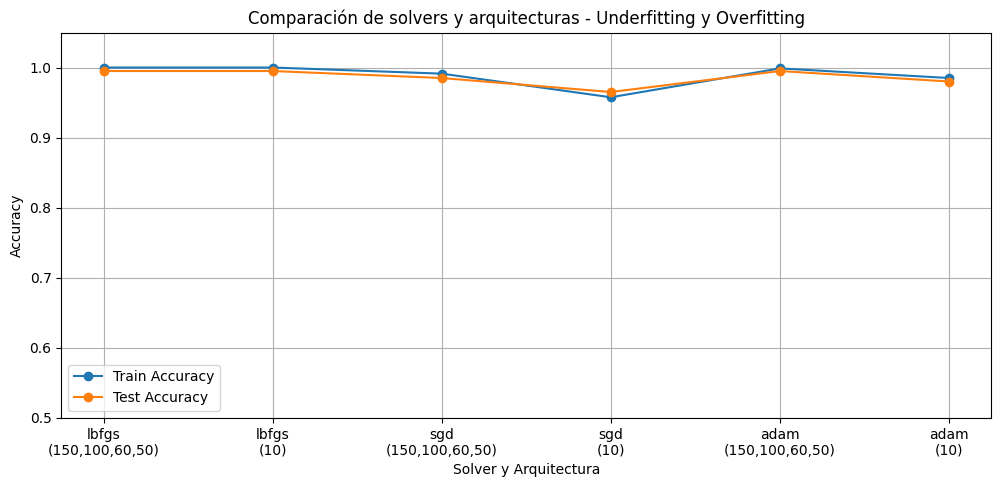

In [67]:
solvers = ['lbfgs', 'sgd', 'adam']
train_scores = []
test_scores = []
x_labels = []  # To store the x-axis labels

for solver in solvers:
    # First configuration
    clf = MLPClassifier(hidden_layer_sizes=(150, 100, 60, 50), solver=solver, max_iter=1000, random_state=42)
    clf.fit(X, y)
    train_score = clf.score(X, y)
    test_score = clf.score(X_test, test_people[:, -1])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    x_labels.append(f"{solver}\n(150,100,60,50)")
    print(f"Solver: {solver} | Train Acc: {train_score:.3f} | Test Acc: {test_score:.3f}")
    
    # Second configuration
    clf = MLPClassifier(hidden_layer_sizes=(10), solver=solver, max_iter=1000, random_state=42)
    clf.fit(X, y)
    train_score = clf.score(X, y)
    test_score = clf.score(X_test, test_people[:, -1])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    x_labels.append(f"{solver}\n(10)")
    print(f"Solver: {solver} | Train Acc: {train_score:.3f} | Test Acc: {test_score:.3f}")

# Visualización
plt.figure(figsize=(12,5))
plt.plot(x_labels, train_scores, label='Train Accuracy', marker='o')
plt.plot(x_labels, test_scores, label='Test Accuracy', marker='o')
plt.title("Comparación de solvers y arquitecturas - Underfitting y Overfitting")
plt.xlabel("Solver y Arquitectura")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.05)
plt.grid(True)
plt.legend()
plt.show()

**Conclusiones:**

Los resultados nos dicen lo siguiente:

- Mejor rendimiento general → lbfgs

Tiene la mayor precisión en test (99.5%) y un entrenamiento perfecto (100%).

- Alternativa eficiente → adam

Casi igual de bueno que lbfgs (98.75-99.2%).

Finalmente vemos que si bien el sgd cumple con su cometido, es el más inestable de los 3 y tiene una precisión general ligeramente inferior. De todas formas no deja de ser una herramienta que podría tener su momento para brillar.

***
**Jaime Alonso Fernández**  
**Universidad Complutense de Madrid**  
**Grado en Ingeniería del Software (Plan 2019)**  
**Asignatura de Aprendizaje Automático y Big Data**
***

